# Resumes Parsing and Natural Language Processing (NLP)
* Aurthor: Tommy Lam
* Date: 15 Mar 2020

PDF, one of the famous formats of documents, at the same time it is also a nightmare to us while we want to convert them into text format. They look like usual documents when we read them. However, they feel like pictures when we need to edit or convert them into text.

This project firstly provides a way to parse read these notorious pdf files and convert them into text format. Around 850 resumes are used to illustrate the pdf parsing. 
After the conversion, basic NLP (natural language processing) is used to investigate what is the most common topics/skills are included among the resumes.

Data for this study is one of the resources from my master degree at Monash University. The data is a huge set of resume in pdf format, same as those we have seen in our daily live or online. Therefore, any resumes can also be used in this project. 

This project is useful for those who need to handle a huge amount of text information such as HR handling more than 200 resumes, researchers studying linguistics, artificial intelligence to learn languages and so on.

## Required Libraries

In [27]:
# data processing
import pandas as pd

In [28]:
# text processing
import re 
import nltk
from nltk.collocations import *
from nltk.stem import *
from nltk.stem.porter import *

In [54]:
# visualisation
import seaborn as sns #basic charts
import matplotlib.pyplot as plt #plot setup
from wordcloud import WordCloud #word cloud

In [5]:
# PDF parsing
from pdfminer.converter import TextConverter
from pdfminer.pdfinterp import PDFPageInterpreter
from pdfminer.pdfinterp import PDFResourceManager
from pdfminer.pdfpage import PDFPage

In [48]:
# miscellaneous 
import io
import os

## Read the pdf documents

1. Define a function to extract pdf file type
 * Expected input: pdf file path
 * Output: text in the pdf file 

Note: This is the basic usage of this library to obtain the text content assuming the pdf are in plain format. There are actually various kinds of pdf's features can be captured by this library such as Layout Analysis to identify the layout of pdf or obtaining table of contents. We can find more details of the PDFmniner on their page: https://pdfminer-docs.readthedocs.io/programming.html.


In [10]:
def extract_text_from_pdf(pdf_path):
    resource_manager = PDFResourceManager()
    temporary_file = io.StringIO() # Text content will be included in this object
    converter = TextConverter(resource_manager, temporary_file) 

    # check if the pdf path is workable
    try:
        page_interpreter = PDFPageInterpreter(resource_manager, converter)
    except:
        print(pdf_path + ' is not working.')

    # open the file and read the pdf
    with open(pdf_path, 'rb') as fh:
        for page in PDFPage.get_pages(fh, 
                                      caching=True,
                                      check_extractable=True):
            page_interpreter.process_page(page)
            
        text = temporary_file.getvalue()
    
    # close open handles
    converter.close()
    temporary_file.close()
    
    if text:
        return text

Here, we will parse all pdf documents in a designated file location. Therefore, firstly, we will list all files availble in the directory.

In [11]:
import os

# List all files in a directory using os.listdir
basepath = 'data/resume/'
name_list = []
for entry in os.listdir(basepath):
    if os.path.isfile(os.path.join(basepath, entry)):
        name_list.append(entry)
name_list.sort() # sort the file names

In [13]:
print('There are '+str(len(name_list))+' documents available in this location')
print('First five documents:')
for i in name_list[0:5]: 
    print(' - '+i)

There are 863 documents available in this location
First five documents:
 - resume_(1).pdf
 - resume_(10).pdf
 - resume_(100).pdf
 - resume_(101).pdf
 - resume_(102).pdf


In [14]:
%%time
# read documents as texts in a list 
documents = []
for each in name_list:
    documents.append(extract_text_from_pdf('data/resume/'+each))

CPU times: user 5min 57s, sys: 8.75 s, total: 6min 6s
Wall time: 8min 2s


## Tokenization
Tokenization is one of the big steps when we start to analysis text contents. This process breaks every sentences, paragraphs, passage into single words (we called them tokens). For example, 'Data science is the future' is tokenized into a bag of words 'Data','science','is','the','future'. 

We can do this by library re to split the sentences manually or using tokenize function built-in library nltk.

Note: For nltk library, some machines may require to download the 'punkt' file before performing tokenization.

In [34]:
%%time
# convert each text of documents into tokens (tokenize)
# nltk.download('punkt') 
doc_token  = [nltk.word_tokenize(doc) for doc in documents]

CPU times: user 6.57 s, sys: 264 ms, total: 6.83 s
Wall time: 8.82 s


## Normalization
There are some procedures we can do in order to enhance the performance of NLP, we called them normalization.

For example: 
1. Tokens are all turned to lower case, to avoid 'Apple' is not to 'apple' situation.
2. All tokens with length less than 3 are removed since those with less than 3 alphabets can not provide much information in this scenario. Of course, this depends on the kinds of documents we are studying and the contexts we are interested in.
3. Numerical tokens are also removed
4. Tokens are in the stopwords list are also removed (explain in the following)

#### Stopwords: 
* Stopwords are those commonly used words (such as 'the','a','an'). These words are mostly ignored in the search engine. We can assume that these stopwords are less related to the context we interested in, i.e. job application. 
* There are numerous sets of stopwords available online. In this project, the following one will be adopted: http://www.lextek.com/manuals/onix/stopwords1.html

In [35]:
## read stopwords
file = open("data/stopwords.txt", "r") 
readline = file.readlines()
stopwords = [each[0:-1] for each in readline]
print('Number of stopwords: '+str(len(stopwords)))

Number of stopwords: 429


In [36]:
### Define a function to normalise tokens
def normalise(token_input):
    token_set = set()

    ## lowercase, remove token with length less than 3 and non-numeric and those in stopwords
    token_lower = [each.lower() for each in token_input]

    #remove length < 3 and non-numeric
    token_len = [each for each in token_lower if (len(each)>2 and re.match("[a-z|A-Z]",each) != None)]

    #remove those in stopwords
    token_stop = [each for each in token_len if each not in stopwords]

    return token_stop

In [37]:
%%time
token_normalised = [normalise(each) for each in doc_token]

CPU times: user 3.39 s, sys: 55.3 ms, total: 3.45 s
Wall time: 4.64 s


## Popular words in resumes
So what are the popular mentions among all these resumes? Will they be meaningful words? Are they skills related or experience related?

Alright, now we are building dataframe to count the occurrence of the words appearing in the documents.

First, a 'dictionary' containing the set of the token without repeating is built.

In [38]:
# join all the token lists to create a full 'token dictionary'. 
# convert to set such that duplicates would be removed
token_dictionary = list(sorted(set(sum(token_normalised,[]))))

In [39]:
token_count = pd.DataFrame({'token': token_dictionary})
token_count.head()

,token
0,a'business'to'business'module'by'marketing'and...
1,a'framework'of'credit'risk'profiling'to'have'i...
2,a'key'role'in'developing*the*company*image*amo...
3,a'leadership'role'in'coordinating
4,a'wide'territory


We may find some unusual 'words' in the token list, those are wrongly read by pdfminer. However, these are only small parts in the dataset so we can simply ignore them. 
Next, we are counting the occurrence of each token. We will count them one per each document to make sure they will not be multiple counted in case some of the words are mentioned overwhelmingly in only part of the documents.

In [40]:
%%time
count_list = [0]* len(token_dictionary)
for i in range(0,len(token_dictionary)):
    for j in range(0,len(token_normalised)):
        if token_dictionary[i] in token_normalised[j]:
            count_list[i] += 1

CPU times: user 2min 53s, sys: 2.25 s, total: 2min 56s
Wall time: 3min 30s


In [41]:
#Create table
token_count['Count'] = count_list
token_count = token_count.sort_values('Count',ascending=False).reset_index(drop =True)
token_count.head(5)

,token,Count
0,management,769
1,university,752
2,experience,751
3,financial,720
4,education,705


Let's visualise them in a bar chart.

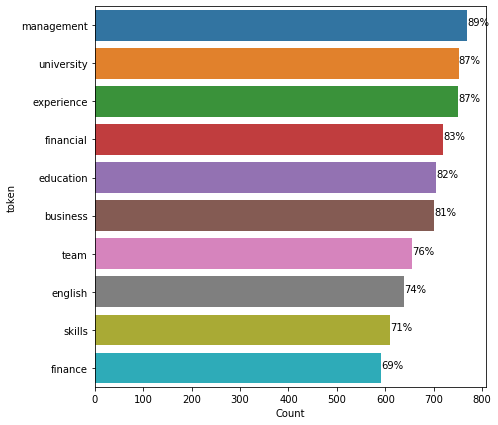

In [42]:
plt.figure(figsize=(7,7))
chart = sns.barplot( x= 'Count', y = 'token',data = token_count[0:10])

# add value label
for index, row in token_count[0:10].iterrows():
    chart.text( row.Count,row.name,str(round(row.Count/len(documents)*100))+'%', color='black')
chart

Among the top mentions,'university','experience' and 'skiils' are expected since they are the categories that we usually put in a resume. 

## Bigram analysis
Bigram is a sequence of words with adjacent elements from sentences or tokens. For example, a sequence of 'extensive financial experience' will become 'extensive financial' and 'financial experience'. We believe the combination of words such as bigram or more (we called n-gram) gives more insights than just tokens (unigram).

Bigram can be easily built by nltk.bigrams function. They are stored in the form of a list of tuples.

In [45]:
doc_bigram = [list(nltk.bigrams(each))for each in token_normalised]
print(doc_bigram[1][1:5])

[('lapaire', 'date'), ('date', 'birth'), ('birth', 'april'), ('april', 'nationality')]


Let's count the occurrence of bigrams in documents.

Similar to unigram, we will first build a bigram dictionary and scan them through each document to check the occurrence.

In [46]:
# join all the bigrams lists to create a full 'bigrams dictionary'. 
# convert to set such that duplicates would be removed
bigram_dictionary = list(sorted(set(sum(doc_bigram,[]))))

In [47]:
bigram_count = pd.DataFrame({'bigram': bigram_dictionary})
bigram_count['label'] = bigram_count.bigram.apply(lambda x: x[0]+' '+x[1])
bigram_count.head(5)

,bigram,label
0,(a'business'to'business'module'by'marketing'an...,a'business'to'business'module'by'marketing'and...
1,(a'framework'of'credit'risk'profiling'to'have'...,a'framework'of'credit'risk'profiling'to'have'i...
2,(a'key'role'in'developing*the*company*image*am...,a'key'role'in'developing*the*company*image*amo...
3,"(a'leadership'role'in'coordinating, banks)",a'leadership'role'in'coordinating banks
4,"(a'wide'territory, emea)",a'wide'territory emea


Due to the fact that bigrams are built from the combination of monogram, the list of bigrams is much longer than that of monograms. Therefore, it takes almost 20 times longer to scan through all documents.

In [22]:
%%time
bigram_count_list = [0]* len(bigram_dictionary)
for i in range(0,len(bigram_dictionary)):
    for j in range(0,len(doc_bigram)):
        if bigram_dictionary[i] in doc_bigram[j]:
            bigram_count_list[i] += 1

CPU times: user 37min 13s, sys: 4.89 s, total: 37min 18s
Wall time: 37min 25s


In [23]:
#Create table
bigram_count['Count'] = bigram_count_list
bigram_count = bigram_count.sort_values('Count',ascending=False).reset_index(drop =True)
bigram_count.head(5)

,bigram,label,Count
0,"(hong, kong)",hong kong,368
1,"(financial, statements)",financial statements,274
2,"(due, diligence)",due diligence,259
3,"(private, equity)",private equity,250
4,"(microsoft, office)",microsoft office,243


From the following bar chart showing the occurance of bigrams, it gives much more information of the documents than the monogram chart.

We can observe that these 850 resumes are highly related to Hong Kong and they are mostly related to financial business as those in the top mentions are financial terms.

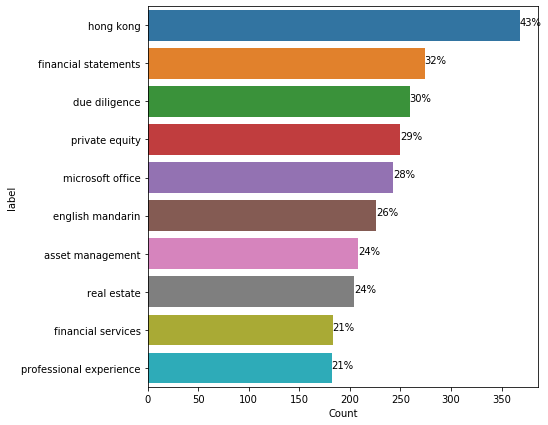

In [84]:
plt.figure(figsize=(7,7))
chart = sns.barplot( x= 'Count', y = 'label',data = bigram_count[0:10])

# add value label
for index, row in bigram_count[0:10].iterrows():
    chart.text( row.Count,row.name,str(round(row.Count/len(documents)*100))+'%', color='black')
chart

## Word Cloud visualisation

In this section I will demonstrate a famous tool to visualise text data, Word Cloud. Word cloud visualises the text with larger size with high occurances and locates the words with similar pattern together such as the 'hong'+'kong' and 'financial'+'statement' in the following word cloud.

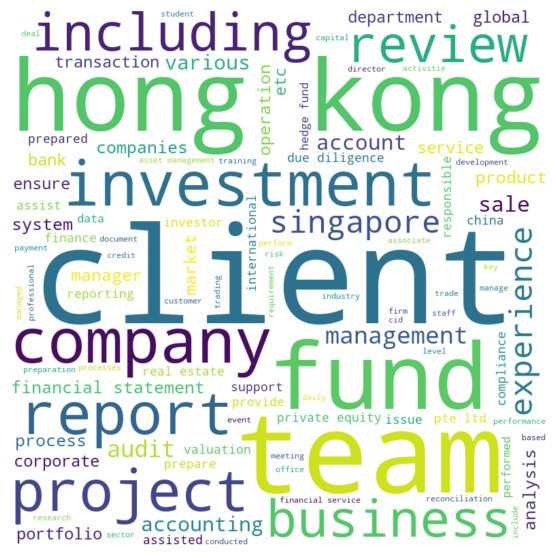

CPU times: user 6.81 s, sys: 960 ms, total: 7.77 s
Wall time: 7.79 s


In [88]:
%%time
# Word cloud for tokens
 
# Create a list of word
text=' '.join(sum(token_normalised,[]))
 
# Create the wordcloud object
wordcloud = WordCloud(width=800, height=800, margin=10
                      , max_words=100
                      , background_color="white").generate(text)
 
# Display the generated image:
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()


## Stemming
 Some of you may observe that there are similar words in the top monogram chart, i.e. 'financial' vs 'finance'. These are the words sharing the same root. When we try to stem the token, which means convert them into basic form. (in this case, 'financial' and 'finance' into 'financ')

* Stemming is actually one of processes in the normalisation. In the previous section, I excluded the stemming process such that the bar chart and word cloud are showing full tokens instead of stemmed one.

* Stemmed tokens perform better when we need to further analyse the text data in classification / sentimental analysis.

Stemming can be done by using stem.porter from NLTK library.

In [99]:
##Stemming
from nltk.stem import *
from nltk.stem.porter import *
stemmer = PorterStemmer()
stemmed_token = [stemmer.stem(each) for each in token_dictionary]
stemmed_token = list(set(stemmed_token))
stemmed_token.sort()
print('Number of tokens before stemming: '+str(len(token_dictionary))) #before stemming
print('Number of tokens after stemming: '+str(len(stemmed_token))) #after stemming
print('')
print(str(len(token_dictionary) - len(stemmed_token)) +' tokens are reduced after stemming')

Number of tokens before stemming: 26011
Number of tokens after stemming: 21145

4866 tokens are reduced after stemming


In [100]:
### Define a function to normalise tokens
def stemming(token_input):

    ## lowercase, remove token with length less than 3 and non-numeric and those in stopwords
    token_stemmed = [stemmer.stem(each) for each in token_input]

    return token_stemmed

In [101]:
token_stemmed = [stemming(each) for each in token_normalised]

In [102]:
# join all the token lists to create a full 'token dictionary'. 
# convert to set such that duplicates would be removed
token_stemmed_dictionary = list(sorted(set(sum(token_stemmed,[]))))
token_stemmed_count = pd.DataFrame({'token': token_stemmed_dictionary})
token_stemmed_count.head()

,token
0,a
1,a'business'to'business'module'by'marketing'and...
2,a'framework'of'credit'risk'profiling'to'have'i...
3,a'key'role'in'developing*the*company*image*amo...
4,a'leadership'role'in'coordin


In [103]:
%%time
count_list = [0]* len(token_stemmed_dictionary)
for i in range(0,len(token_stemmed_dictionary)):
    for j in range(0,len(token_stemmed)):
        if token_stemmed_dictionary[i] in token_stemmed[j]:
            count_list[i] += 1
            
#Create table
token_stemmed_count['Count'] = count_list
token_stemmed_count = token_stemmed_count.sort_values('Count',ascending=False).reset_index(drop =True)

CPU times: user 2min 1s, sys: 593 ms, total: 2min 2s
Wall time: 2min 3s


Let's visualise them in a bar chart.

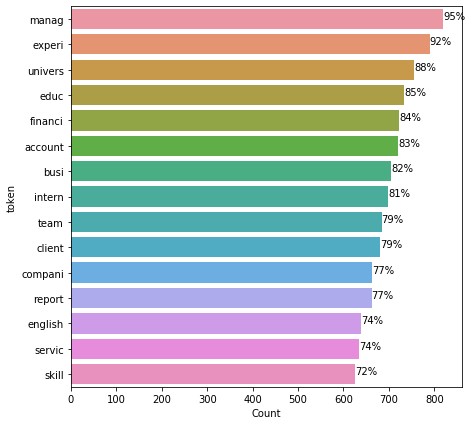

In [110]:
plt.figure(figsize=(7,7))
chart = sns.barplot( x= 'Count', y = 'token',data = token_stemmed_count[0:15])

# add value label
for index, row in token_stemmed_count[0:15].iterrows():
    chart.text( row.Count,row.name,str(round(row.Count/len(documents)*100))+'%', color='black')
chart

After stemming, we can observe that 95% of the resumes include the keywords related to manage and finance (excluding experience/university/education).

## Summary
* By using PDFminer, we can parse the pdf file into text contents. 
* With the basic Natural Language Processing, the text contents are further tokenised and formed bigrams.
* Word cloud can be used to visualise the text pattern effectively.

## Further
1. We can perform feature selection based on the tokenised documents by filtering the keywords we want and filter the documents we want.
2. Based on the tokens in each document, we can perform unsupervised classification to divide the documents into different clusters.